In [18]:
from moseq2_detectron_extract.io.session import Session
import matplotlib.pyplot as plt
import numpy as np
import cv2
from frr import FastReflectionRemoval

from moseq2_detectron_extract.proc.proc import prep_raw_frames, clean_frames, get_frame_features


In [2]:
session = Session(r"H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Dulin_Lab\DREADDs Cohort- Ashley Tucker\Week 9 Post Transplantation Post CNO\session_20220819105327.tar.gz")
first_frame, bground_im, roi, true_depth = session.find_roi()

In [3]:
def plot_frames(frames, idxs, cols=5, fig_size=(20,20), vmin=0, vmax=100):
    cols = int(cols)
    rows = int(np.ceil(frames.shape[0] / cols))
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=fig_size)
    
    for i, ax in enumerate(axs.flat):
        im = ax.imshow(frames[i], vmin=vmin, vmax=vmax)
        ax.set_title(idxs[i])
    fig.colorbar(im)
    fig.tight_layout()

def plot_contours(frames, contours, idxs, cols=5, fig_size=(20,20), vmin=0, vmax=100):
    cols = int(cols)
    rows = int(np.ceil(frames.shape[0] / cols))
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=fig_size)
    norm = plt.Normalize(vmin, vmax)
    cmap = plt.get_cmap('jet')
    
    disp_img = frames.copy().astype('float32')
    disp_img = (disp_img-vmin)/(vmax-vmin)
    disp_img[disp_img < 0] = 0
    disp_img[disp_img > 1] = 1
    disp_img = cmap(disp_img)[:,:,:,:3]*255
    
    for i, ax in enumerate(axs.flat):
        cv2.drawContours(disp_img[i], [contours[i]], -1, (0,255,255), 1)
        ax.imshow(disp_img[i])
        ax.set_title(idxs[i])
    fig.tight_layout()

In [4]:
frames_of_interest = range(200, 220)
frame_idxs, raw_frames = next(session.index(frames_of_interest))

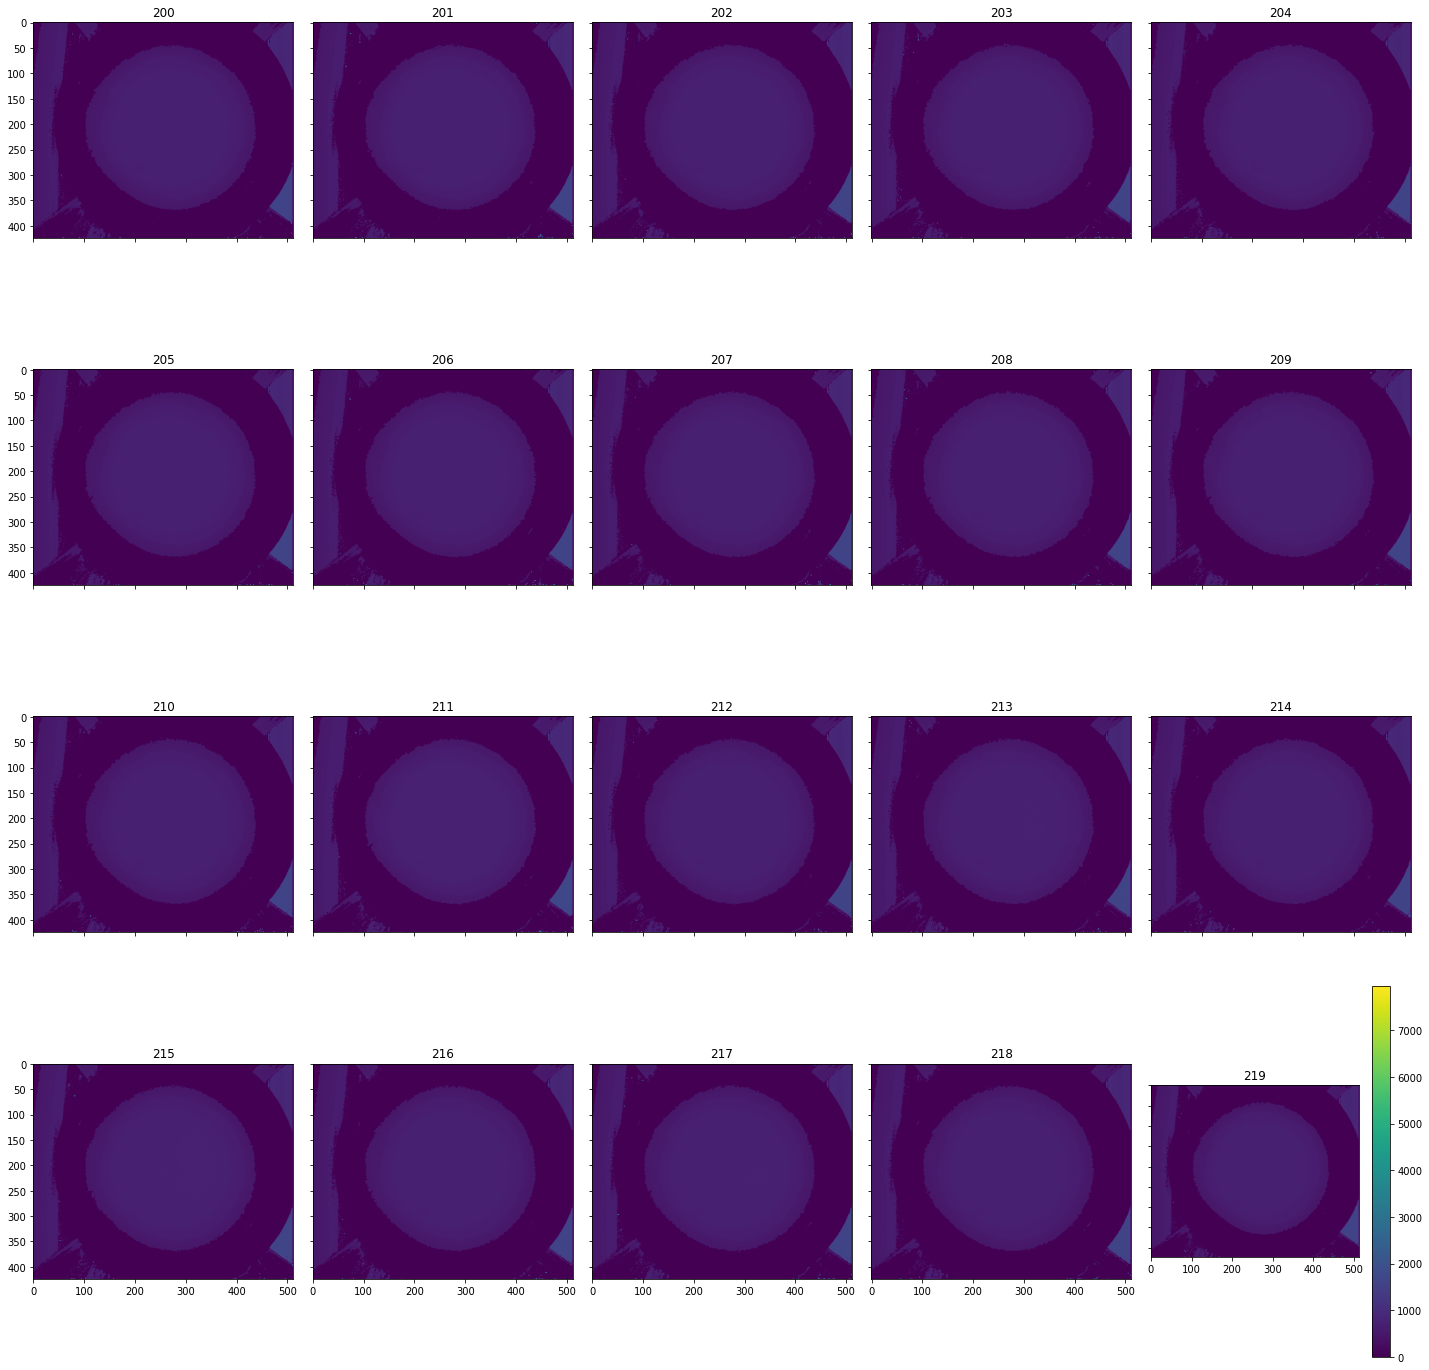

In [5]:
plot_frames(raw_frames, frame_idxs, vmin=None, vmax=None)

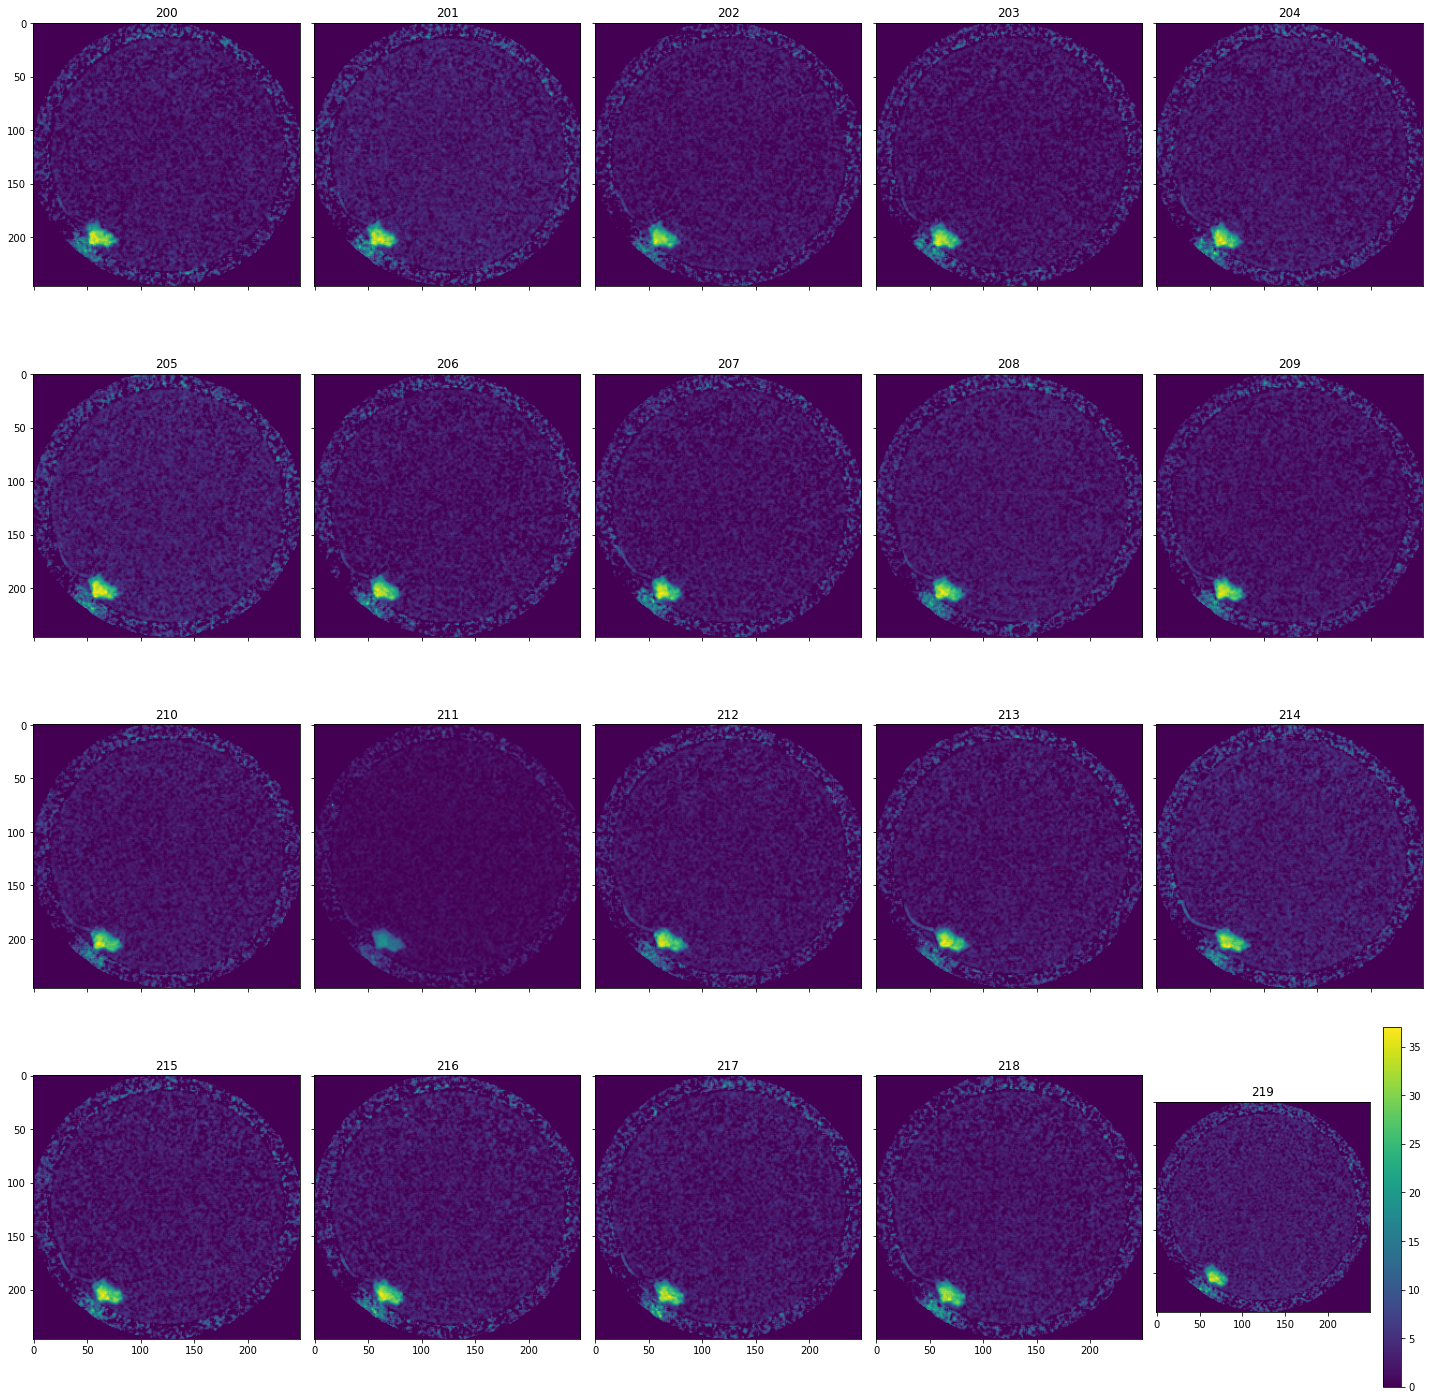

In [8]:
plot_frames(prep_raw_frames(raw_frames.copy(), bground_im=bground_im, roi=roi, vmin=0, vmax=100, fix_invalid_pixels=True), frame_idxs, vmin=0, vmax=None)

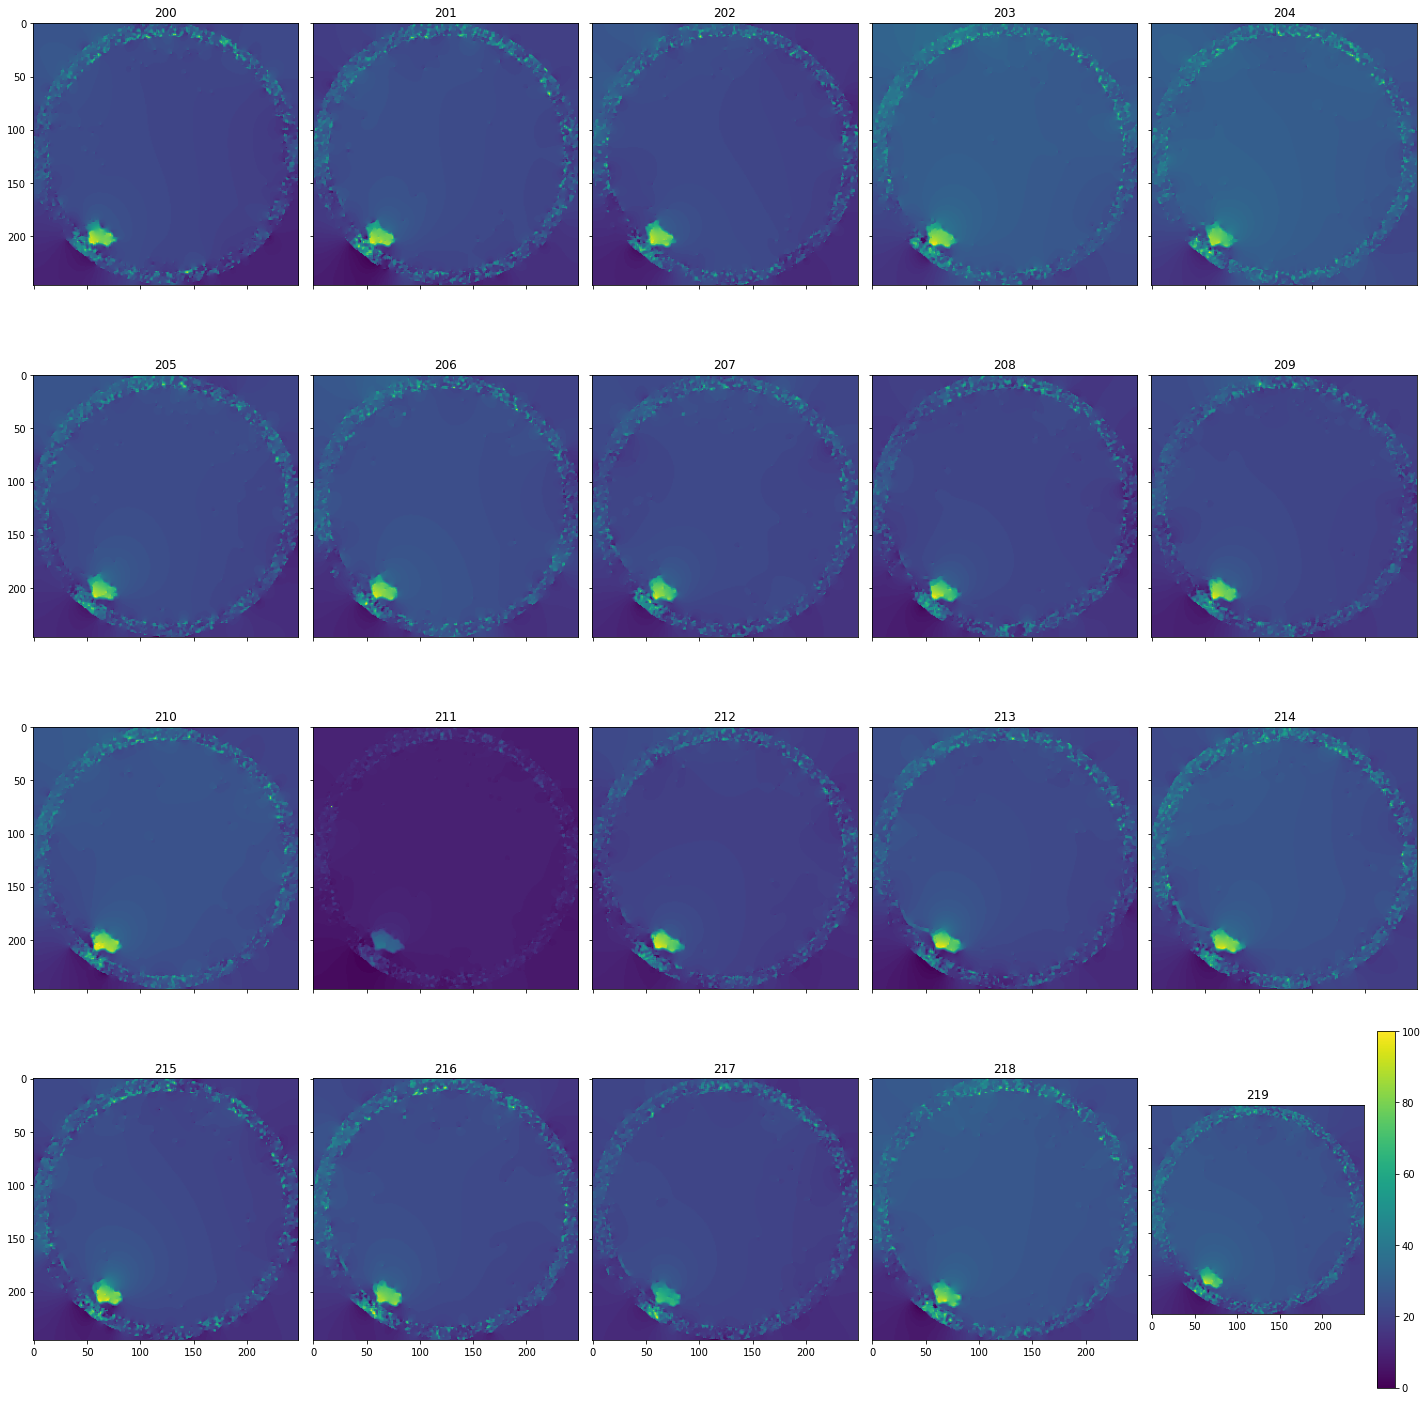

In [29]:

alg = FastReflectionRemoval(h=0.05)
frames = prep_raw_frames(raw_frames.copy(), bground_im=bground_im, roi=roi, vmin=0, vmax=100, fix_invalid_pixels=True)
denoised = np.zeros_like(frames)
for i in range(denoised.shape[0]):
    factor = 100.0 #frames[i].max()
    denoised[i] = (alg.remove_reflection(frames[i, :, :, None].astype('float') / factor) * factor)[:,:,0].astype('uint8')


plot_frames(denoised, frame_idxs, vmin=0, vmax=100)

In [24]:
%%timeit -n 36 -r 3 
#missing_pixels = np.nonzero(raw_frames == 0)
mask = np.zeros_like(raw_frames, dtype='uint8')
mask[raw_frames == 0] = 1
mask = prep_raw_frames(mask, roi=roi)

preped_raw_frames = prep_raw_frames(raw_frames.copy(), bground_im=bground_im, roi=roi, vmin=0, vmax=100)
filled_raw_frames = prep_raw_frames(raw_frames.copy(), bground_im=bground_im, roi=roi, vmin=0, vmax=100)
for i in range(mask.shape[0]):
    filled_raw_frames[i] = cv2.inpaint(filled_raw_frames[i], mask[i], 3, cv2.INPAINT_NS)


#plot_frames(filled_raw_frames, frame_idxs, vmin=None, vmax=None)

3.93 s ± 7.02 ms per loop (mean ± std. dev. of 3 runs, 36 loops each)


In [25]:
%%timeit -n 36 -r 3 
mask = np.zeros_like(raw_frames, dtype='uint8')
mask[raw_frames == 0] = 1
mask = prep_raw_frames(mask, roi=roi)

preped_raw_frames = prep_raw_frames(raw_frames.copy(), bground_im=bground_im, roi=roi, vmin=0, vmax=100)
filled_raw_frames = prep_raw_frames(raw_frames.copy(), bground_im=bground_im, roi=roi, vmin=0, vmax=100)
for i in range(mask.shape[0]):
    filled_raw_frames[i] = cv2.inpaint(filled_raw_frames[i], mask[i], 3, cv2.INPAINT_TELEA)

4.15 s ± 31.2 ms per loop (mean ± std. dev. of 3 runs, 36 loops each)
